## Developing and Testing Code for dynamic_spectra.py

In [9]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline
import os
import cv2
from skimage.draw import polygon2mask
from skimage.measure import find_contours
import pywt
import tifffile

## Load Data

In [5]:
mouse = "cmm002mjr"
path_behavior = '//tsclient/T7 Shield2/BehaviorDataBackup/VoltageMice/' + mouse + "/PerceptualData_" + mouse +"_all.mat"

def movie_path(mouse, date, file):
    return "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF.h5'

path_movie = movie_path(mouse, 231213, 'meas03')

In [12]:
with h5py.File(path_movie, 'r') as mov_file:
    specs = mov_file["specs"]
    mov = mov_file['mov'][()]

    fps = specs['fps'][()][0][0][0]
    
    # Extract raw outlines
    raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()]
    raw_mask = specs["extra_specs"]["mask"][()][0]
    
    # Get binning and space origin
    binning = specs["binning"][()][0][0][0]  # Extract binning factor
    spaceorigin = specs["spaceorigin"][()].flatten()  # Load space origin
    spaceorigin = (spaceorigin - 1) / binning + 1  # Apply space origin transformation

    # Select outlines (default all if not specified)
    outlines_nums = np.arange(raw_outlines.shape[2])  # Equivalent to 1:size(raw_outlines, 3)
    
    # Adjust outlines
    outlines = raw_outlines[:, :, outlines_nums] / binning
    outlines[:, 0, :] -= spaceorigin[1] - 1  # Adjust Y-coordinates
    outlines[:, 1, :] -= spaceorigin[0] - 1  # Adjust X-coordinates

movie = np.nan_to_num(mov)

## Mask Movie

### Masking Outside Brain & Large Vessels

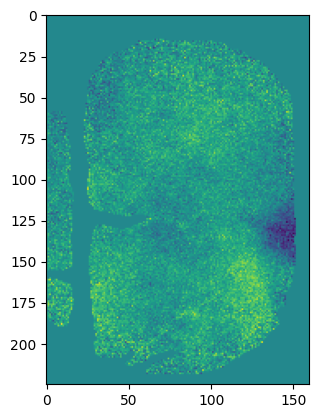

In [13]:
def mask_movie(movie, raw_mask, binning):
    # Resize the mask using bilinear interpolation
    mask = cv2.resize(raw_mask, (0, 0), fx=1/binning, fy=1/binning, interpolation=cv2.INTER_LINEAR)
    # Ensure mask has the same shape as the movie
    movie_size = movie.shape[1:3]  # Get spatial dimensions of the movie
    mask = mask[:movie_size[0], :movie_size[1]]  # Crop mask to match movie size
    mask = mask.astype(bool)         # Convert to boolean mask
    return movie * mask  # Apply mask

movie_masked = mask_movie(movie, raw_mask, binning)

plt.imshow(movie_masked[0])

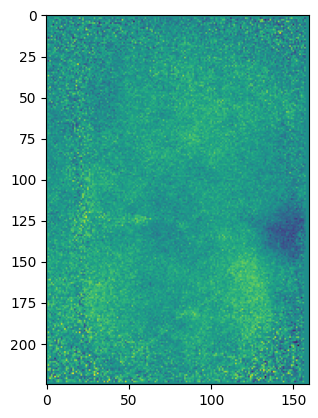

In [15]:
plt.imshow(movie[0])

### ROI Masking

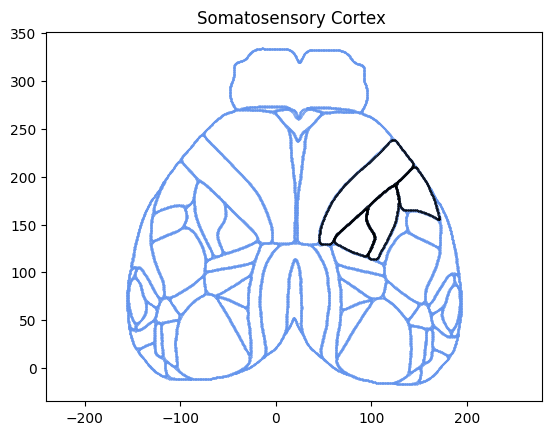

Text(0.5, 1.0, 'Primary Visual Cortex')

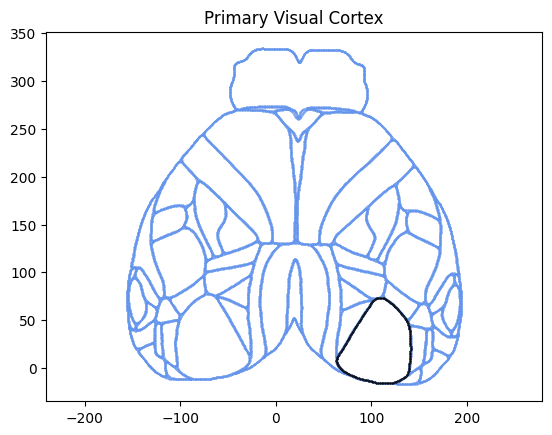

In [5]:
# **Plot the Allen Outlines**
for i in range(outlines.shape[0]):  
        x = outlines[i, 1, :]
        y = outlines[i, 0, :]

        plt.scatter(x, y, s=0.1, c='cornflowerblue')  
        
for j in [3,11,13,15]:
        plt.scatter(outlines[j, 1, :], outlines[j, 0, :], c='black', s=0.1)
 
        plt.axis("equal")  # Keep aspect ratio
        plt.title("Somatosensory Cortex ")
plt.show()

for i in range(outlines.shape[0]):  
        x = outlines[i, 1, :]
        y = outlines[i, 0, :]

        plt.scatter(x, y, s=0.1, c='cornflowerblue')  

plt.scatter(outlines[37, 1, :], outlines[37, 0, :], c='black', s=0.1)

plt.axis("equal")  # Keep aspect ratio
plt.title("Primary Visual Cortex")

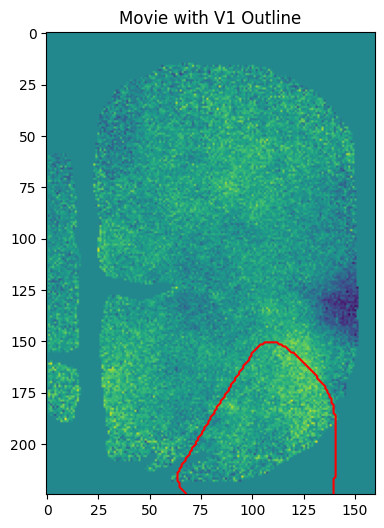

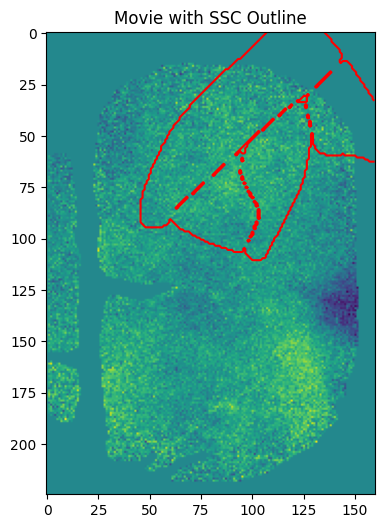

In [6]:
def mask_region(movie, raw_outlines, binning, spaceorigin, region, plot=False):
    if region == 'V1':
        indices=[37]
    elif region == 'SSC':
        indices=[3,11,13,15]
    else:
        print('Region must be V1 or SSC')

    spaceorigin = (spaceorigin - 1) / binning + 1  # Apply space origin transformation

    # Select outlines (default all if not specified)
    outlines_nums = np.arange(raw_outlines.shape[2])  # Equivalent to 1:size(raw_outlines, 3)
    
    # Adjust outlines
    outlines = raw_outlines[:, :, outlines_nums] / binning
    outlines[:, 0, :] -= spaceorigin[1] - 1  # Adjust Y-coordinates
    outlines[:, 1, :] -= spaceorigin[0] - 1  # Adjust X-coordinates

    # Define the movie dimensions
    movie_shape = movie.shape[1:3]  # (height, width)
            
    if plot:
    # Plot the movie frame
        plt.figure(figsize=(6, 6))
        plt.imshow(movie[0])  # Display movie frame
        plt.title(f"Movie with {region} Outline")

    total_mask = np.zeros(movie_shape, dtype=bool)

    for i in indices:
        # Extract the ROI outline
        outline = outlines[i, :, :]  # Shape (2, N)

        valid_indices = ~np.isnan(outline).any(axis=0)  # Find non-NaN indices
        x_coords = outline[1, valid_indices]
        y_coords = outline[0, valid_indices]

        # Create a mask using polygon2mask
        roi_mask = polygon2mask(movie_shape, np.column_stack((y_coords, x_coords)))
        roi_mask = np.flipud(roi_mask).astype(bool)
        total_mask |= roi_mask  # Any pixel belonging to at least one ROI remains unmasked

    # Apply mask to the movie
    movie_roi = movie * total_mask  # Broadcasting applies the mask to all frames

    # Find contours of the ROI mask
    contours = find_contours(total_mask, level=0.5)  # Extract the outline

    if plot:
        # Overlay the mask outline
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1.5)  # Plot contour in red
    plt.show()

    return movie_roi

movie_v1 = mask_region(movie_masked, raw_outlines, binning, spaceorigin, 'V1', plot=True)
movie_ssc = mask_region(movie_masked, raw_outlines, binning, spaceorigin, 'SSC', plot=True)

In [7]:
def load_and_mask(mouse, date, file, region=None):
    path_movie = movie_path(mouse, date, file)

    with h5py.File(path_movie, 'r') as mov_file:
        specs = mov_file["specs"]
        mov = mov_file['mov'][()]  
        fps = specs["fps"][()][0][0][0]  
        raw_mask = specs["extra_specs"]["mask"][()][0]
        binning = specs["binning"][()][0][0][0]  
        raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()]
        spaceorigin = specs["spaceorigin"][()].flatten()  

    movie = np.nan_to_num(mov)
    movie = mask_movie(movie, raw_mask, binning)

    if region:
        movie = mask_region(movie, raw_outlines, binning, spaceorigin, region, plot=False)

    return movie, fps

## Plotting Results

### Power Spectrum

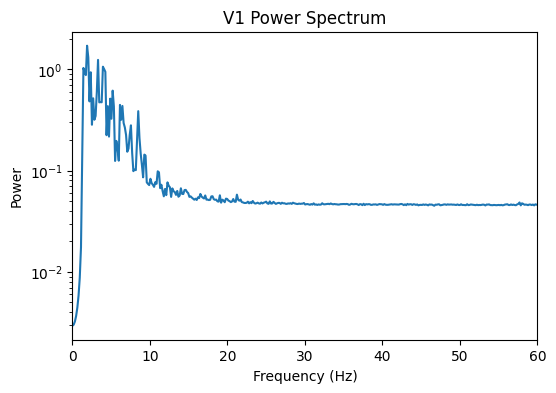

In [8]:
def power_spectrum(movie, plot=True, title="Power Spectrum"):
    # Assume movie is a 3D NumPy array with shape (time, height, width)
    # Assume fps is the frame rate of the movie
    t_dim, x_dim, y_dim = movie.shape
    # Compute FFT along the time axis for the entire movie
    fft_result = np.fft.fft(movie, axis=0)

    # Compute the power spectrum (squared magnitude of FFT)
    power_spec = np.abs(fft_result) ** 2

    # Average over all pixels to get a single power spectrum
    global_power_spectrum = np.mean(power_spec, axis=(1, 2))

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(t_dim, d=1/fps)  # Assuming fps is the frame rate

    # Keep only the positive frequencies
    positive_freqs = freqs[:t_dim // 2]
    global_power_spectrum = global_power_spectrum[:t_dim // 2]

    if plot:
        # Plot the power spectrum
        plt.figure(figsize=(6, 4))
        plt.plot(positive_freqs, global_power_spectrum)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Power")
        plt.title(title)
        plt.yscale("log")  # Log scale for better visualization
        plt.xlim([0,60])
        plt.show()

    return global_power_spectrum, positive_freqs

power_spec = power_spectrum(movie, title="V1 Power Spectrum")

## Trial Extraction

In [9]:
def find_trials(df, **filters):
    """
    Finds trials from df that match the specified properties.

    Args:
    - df (pd.DataFrame): DataFrame containing trial information.
    - filters (dict): Key-value pairs of column names and values to filter by.
      - Supported keys include 'Date', 'Recording', 'PerceptualCat', 'Rewarded', etc.
      - If a parameter is not specified, it is ignored in filtering.

    Returns:
    - pd.DataFrame: Filtered dataframe containing TrialID, BFMTime, Duration, and MovieFile.
    """

    # Start with full DataFrame and apply filters dynamically
    filtered_df = df.copy()
    filtered_df = filtered_df[filtered_df['ValidTrial?'] == True] 

    for key, value in filters.items():
        if key in df.columns and value is not None:
            if isinstance(value, list):  # Check if the filter is a list
                filtered_df = filtered_df[filtered_df[key].isin(value)]
            else:
                filtered_df = filtered_df[filtered_df[key] == value]

    return filtered_df[["AnimalCode", "TrialID", "Date", "BFMTime", "Duration", "File", 'ValidTrial?']]

In [11]:
mouse = "cmm002mjr"
date = 231213
file = 'meas02'

df_all = pd.read_csv("trial_info/TrialInfo_cmm002.csv")
df = find_trials(df_all, Date=date, TrialType=["HC Hit (3)", "MC Hit (2)"], File=file)
unique_recordings = df[['AnimalCode', 'File', 'Date']].drop_duplicates() # Identify unique recordings
trial_snippets = {}  
power_specs = []
mean_signals = []

# Load and process movies for each unique recording
for _, row in unique_recordings.iterrows():
    mouse = row['AnimalCode']
    date = row['Date']
    file = row['File']

    movie, fps = load_and_mask(mouse, date, file, region='V1')

    # Step 4: Extract trials for this movie
    df_trials = df[(df['AnimalCode'] == mouse) & (df['Date'] == date) & (df['File'] == file)]

    for _, trial in df_trials.iterrows():
        trial_id = trial['TrialID']  # Unique trial identifier
        bfm_time = trial['BFMTime']  # Trial start time in BFM coordinates
        duration = trial['Duration']

        # Compute frame range for this trial
        start_frame = max(0, int((bfm_time - 0.5) * fps))  # Ensure non-negative index
        end_frame = min(movie.shape[0], int((bfm_time + 1.5) * fps))  # Ensure within bounds
        #start_frame = max(0, int((bfm_time + duration - 1.5) * fps))  # Ensure non-negative index
        #end_frame = min(movie.shape[0], int((bfm_time + duration + 1) * fps))  # Ensure within bounds

        # Extract trial snippet
        trial_clip = movie[start_frame:end_frame]

        # Add trial clip, power spectrum & mean signal to dict/lists
        trial_snippets[trial_id] = trial_clip
        power_spec, freqs = power_spectrum(trial_clip, title=f"{trial_id}Power Spectrum", plot=False)
        power_specs.append(power_spec)
        mean_signals.append(trial_clip.mean(axis=(1, 2)))

In [ ]:
def dynamic_spectrum(signal, fps, plot=False):
    # Define Frequency-Optimized Scales
    scales = np.linspace(1, 150, 150)  # Use more fine-grained scales
    wavelet = 'cmor'  # Complex Morlet wavelet

    # Compute Wavelet Transform
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet, 1 / fps)
    power = np.abs(coefficients) ** 2  # Compute power spectrum

    # Keep Only Frequencies Below 50 Hz
    valid_idx = frequencies <= 50  # Mask for frequencies ≤ 50 Hz
    frequencies = frequencies[valid_idx]
    power = power[valid_idx, :]  # Keep only low-frequency data

    # Normalize Power
    power_norm = (power - np.quantile(power, 0.01, axis=1, keepdims=True)) / np.quantile(power, 0.1, axis=1, keepdims=True)

    if plot:
        # Plot Dynamic Spectrum with Higher
        t = np.linspace(-0.5, 1, trial_clip.shape[0])  # Stimulus at t=0
        t = t[: power.shape[1]]  # Trim to match power.shape[1]
        T, F = np.meshgrid(t, frequencies)  # Generate grid

        plt.figure(figsize=(8, 6))
        plt.pcolormesh(T, F, power_norm * 100, shading='auto', cmap='jet')  # Fine-grained frequency resolution
        plt.colorbar(label="Change of wavelet magnitude (%)")
        plt.xlabel("Time relative to stimulus (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Dynamic Spectrum")
        plt.show()
    
    return power_norm, frequencies

In [12]:
def mean_dynamic_spectrum(trial_info_path, **filters):
    df_all = pd.read_csv(trial_info_path)
    df = find_trials(df_all, **filters)
    unique_recordings = df[['AnimalCode', 'File', 'Date']].drop_duplicates() # Identify unique recordings
    print(f"Found {len(df)} trials in {len(unique_recordings)} recordings")
    all_power_norm = []

    # Load and process movies for each unique recording
    for _, row in unique_recordings.iterrows():
        mouse = row['AnimalCode']
        date = row['Date']
        file = row['File']

        print(f"Loading Recording {date}/{file}")

        movie, fps = load_and_mask(mouse, date, file, region='V1')

        # Extract trials for this movie
        df_trials = df[(df['AnimalCode'] == mouse) & (df['Date'] == date) & (df['File'] == file)]

        i = 1
        for _, trial in df_trials.iterrows():
            print(f"{i}/{len(df_trials)}  ", end="")
            bfm_time = trial['BFMTime']  # Trial start time in BFM coordinates

            # Compute frame range for this trial
            start_frame = max(0, int((bfm_time - 0.5) * fps))  # Ensure non-negative index
            end_frame = min(movie.shape[0], int((bfm_time + 1.5) * fps))  # Ensure within bounds

            # Extract trial snippet
            trial_clip = movie[start_frame:end_frame]

            # Compute dynamic spectrum, add to list 
            power_norm, frequencies = dynamic_spectrum(trial_clip, fps, plot=True)
            all_power_norm.append(power_norm*100)

        print('\n')

    power_arr = np.stack(all_power_norm)
    mean_power_arr = np.mean(power_arr, axis=0)

    # Plot Dynamic Spectrum with Higher
    t = np.linspace(-0.5, 1, 2*fps)  # Stimulus at t=0
    t = t[: mean_power_arr.shape[1]]  # Trim to match power.shape[1]
    T, F = np.meshgrid(t, frequencies)  # Generate grid

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(T, F, power_norm * 100, shading='auto', cmap='jet')  # Fine-grained frequency resolution
    plt.colorbar(label="Change of wavelet magnitude (%)")
    plt.xlabel("Time relative to stimulus (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Average Dynamic Spectrum: ", mouse)
    plt.savefig(f"DS_{mouse}.png")
    plt.show()


In [ ]:
mouse = "cmm002mjr"
date = 231213
file = 'meas02'

mean_dynamic_spectrum("TrialInfo_cmm002.csv",  Date=date, TrialType=["HC Hit (3)", "MC Hit (2)"], File=file)

c:\Users\Katie\Documents\Katie\Code\perception_project\venv\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


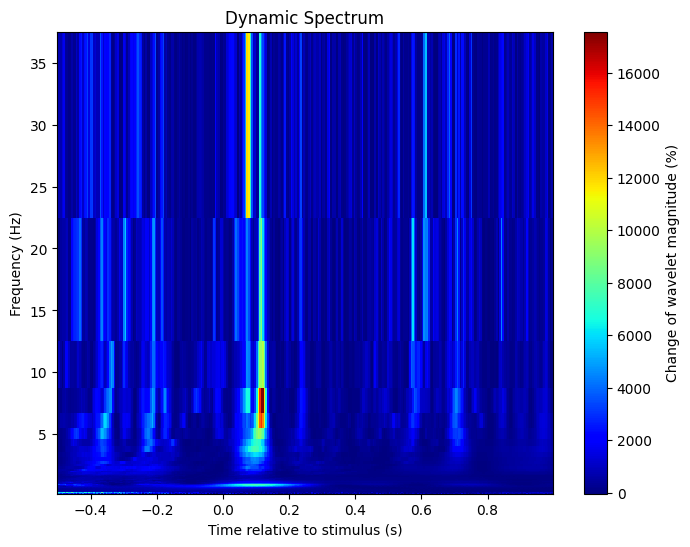

(150, 314)


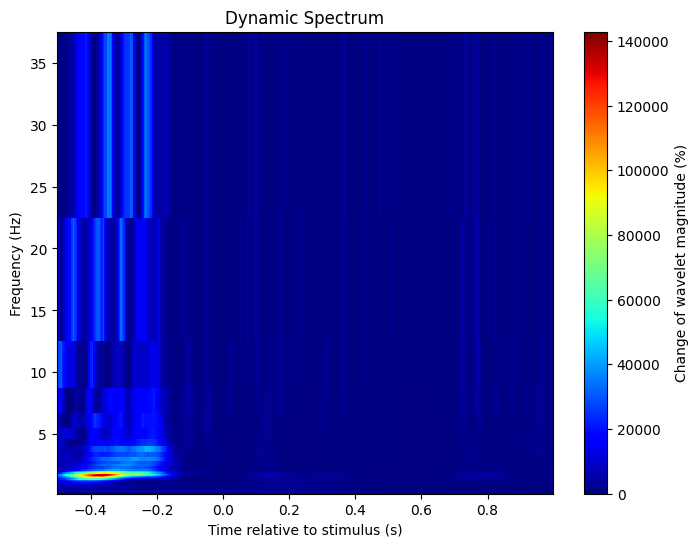

(150, 314)


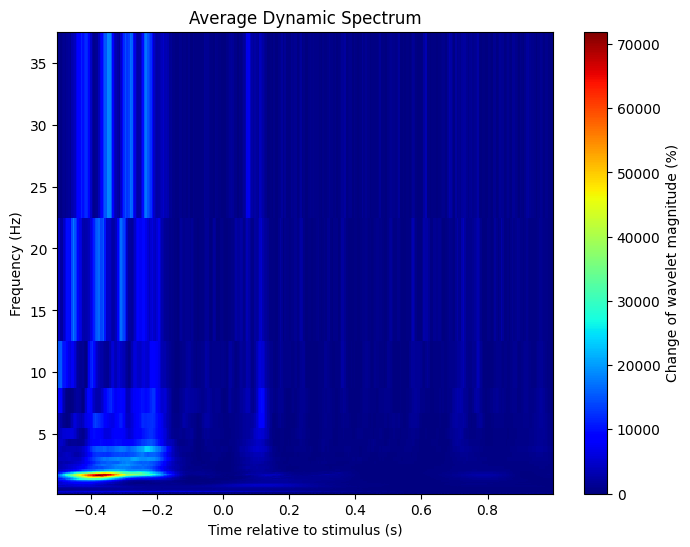

In [ ]:
all_power_norm = []

for i in range(30, 32):
    power_norm, frequencies = dynamic_spectrum(mean_signals[i], plot=True)
    all_power_norm.append(power_norm)

power_arr = np.stack(all_power_norm)
mean_power_arr = np.mean(power_arr, axis=0)

plt.figure(figsize=(8, 6))
plt.pcolormesh(T, F, mean_power_arr * 100, shading='auto', cmap='jet')  # Fine-grained frequency resolution
plt.colorbar(label="Change of wavelet magnitude (%)")
plt.xlabel("Time relative to stimulus (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Average Dynamic Spectrum")
plt.show()